In [2]:
%matplotlib inline

import nibabel as nib
import numpy as np
import subprocess
import nilearn
from nilearn import surface, plotting

In [3]:
hemi = ['L', 'R']
subjects = ['A2002', 'A2003', 'V1001', 'V1002']
dir = 'C:/Users/telec/Documents/Cogmaster/Stage/projects/mri_meg/scripts'

# to save files as gii files
# found the basic building blocks for this here: https://sourcecodequery.com/example-method/nibabel.gifti.gifti.GiftiImageh

for j, s in enumerate(subjects):
    for h in hemi:
        res = np.load('%s/subject%s_comp0_%s.npy' % (dir, s, h))
        garraysl = [nib.gifti.gifti.GiftiDataArray(data=res, datatype='NIFTI_TYPE_FLOAT32', encoding='ASCII')]
        giil = nib.gifti.gifti.GiftiImage(darrays=garraysl)
        nib.save(giil, '%s/subject%s.comp0.%s.shape.gii' % (dir, s, h))

In [4]:
cd C:/Users/telec/Downloads/workbench-windows64-v1.5.0/workbench/bin_windows64

C:\Users\telec\Downloads\workbench-windows64-v1.5.0\workbench\bin_windows64


In [5]:
# above: change of directory necessary for the workbench commands

# creating zone ROIs

ind = 19 # index to select which zone output to use
for h in hemi:
    zone_data = nib.load('%s/zones.fsa5.%s.shape.gii' % (dir, h))
    zone_data_1d = zone_data.darrays[ind].data
    
    garraysl = [nib.gifti.gifti.GiftiDataArray(data=zone_data_1d, datatype='NIFTI_TYPE_FLOAT32', encoding='ASCII')]
    giil = nib.gifti.gifti.GiftiImage(darrays=garraysl)
    nib.save(giil, '%s/zone%i.%s.shape.gii' % (dir, ind, h))
        
    for i in np.unique(zone_data_1d):
        zone_data_bin = np.zeros(10242)
        zone_data_bin[np.where(zone_data_1d == i)] = 1
        
        garraysl = [nib.gifti.gifti.GiftiDataArray(data=zone_data_bin, datatype='NIFTI_TYPE_FLOAT32', encoding='ASCII')]
        giil = nib.gifti.gifti.GiftiImage(darrays=garraysl)
        nib.save(giil, '%s/zone%i.roi%i.%s.shape.gii' % (dir, ind, i, h))
        
        # to 'erode' the rois so that only the centers remain:
        erode_mm = 10 # may need to increase this on an roi-by-roi basis
    
        subprocess.run(['wb_command', 
                        '-metric-erode', 
                        '%s/zone%i.roi%i.%s.shape.gii' % (dir, ind,i,h), 
                        '%s/fsa5.%s.inflated.surf.gii' % (dir, h), 
                        '%i' % erode_mm,
                        '%s/zone%i.roi%i.eroded%i.%s.shape.gii' % (dir, ind,i,erode_mm,h)
                       ],
                        check=True)
    
# not needed, but just a note on how to create ROI:
# wb_command -metric-label-import zone19.roi1.L.shape.gii label_list.txt zone19.roi1.L.label.gii

In [ ]:
# example of visualization of the data on the surfaces

from nilearn import surface, plotting
sL = nilearn.surface.load_surf_mesh('%s/fsa5.L.inflated.surf.gii' % dir)
sR = nilearn.surface.load_surf_mesh('%s/fsa5.R.inflated.surf.gii' % dir)

zL = nilearn.surface.load_surf_data('%s/subjectA2002.zone1.L.shape.gii' % dir) # for a specific subject and a specific zone
zR = nilearn.surface.load_surf_data('%s/subjectA2002.zone1.R.shape.gii' % dir)

nilearn.plotting.plot_surf_roi(sL,zL,view='lateral')
nilearn.plotting.plot_surf_roi(sL,zL,view='medial')
nilearn.plotting.plot_surf_roi(sR,zR,view='lateral')
nilearn.plotting.plot_surf_roi(sR,zR,view='medial')

In [6]:
# find local extrema within each zone for each individual
    
comp=0

for s in subjects:
    for h in hemi:
        surf='%s/fsa5.%s.inflated.surf.gii' % (dir, h)
        gradient_file='%s/subject%s.comp0.%s.shape.gii' % (dir, s, h)
        gradient=nib.load(gradient_file)
        zone_data = nib.load('%s/zones.fsa5.%s.shape.gii' % (dir, h))
        zone_data_1d = zone_data.darrays[ind].data # convert zone gifti file into an array
        for i in np.unique(zone_data_1d):
            zone_roi = nib.load('%s/zone%i.roi%i.eroded%i.%s.shape.gii' % (dir, ind, i, erode_mm, h))
            zone_roi_data = zone_roi.darrays[0].data
            gradient_roi = gradient.darrays[0].data * zone_roi_data # restrict gradient to the ROIs
            garraysl = [nib.gifti.gifti.GiftiDataArray(data=gradient_roi, datatype='NIFTI_TYPE_FLOAT32', encoding='ASCII')]
            giil = nib.gifti.gifti.GiftiImage(darrays=garraysl) # convert into gifti file
            gradient_roi_file = '%s/subject%s.comp0.zone%i.roi%i.eroded%i.%s.shape.gii' % (dir, s, ind, i, erode_mm, h)
            nib.save(giil, gradient_roi_file)

            output='%s/subject%s.zone%i.roi%i.eroded%i.extrema.%s.shape.gii' % (dir, s, ind, i, erode_mm, h)
            subprocess.run(['wb_command', 
                        '-metric-extrema',
                        surf, gradient_roi_file, '30', output, '-presmooth', '6', '-only-maxima'],shell=True)
          

[0. 0. 0. ... 0. 0. 0.]
[[[-24 -63  12]]]
[[  4.133622  -8.32791  -49.849243]
 [ 25.73593   10.243019 -40.637596]
 [-27.354795  19.371479  30.30519 ]]


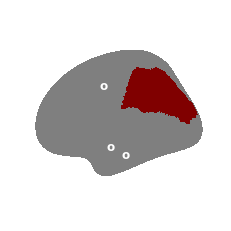

In [12]:
import matplotlib.pyplot as plt
import numpy as np

i = 2
h = 'L'
subject = 'A2002'

# set vertices to plot, loaded from extrema
vertices_file = nilearn.surface.load_surf_data('%s/subject%s.zone%i.roi%i.eroded%i.extrema.%s.shape.gii' % (dir, s, ind, i, erode_mm, h))
vertices = surf[0][np.where(vertices_file),:].astype(int)

# load surface and data
surf = nilearn.surface.load_surf_mesh('%s/fsa5.%s.inflated.surf.gii' % (dir, h))
data = nilearn.surface.load_surf_data('%s/zone%i.roi%i.eroded%i.%s.shape.gii' % (dir, ind, i, erode_mm, h)) 

# plot surface:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
fig = nilearn.plotting.plot_surf_stat_map(surf, data, view='lateral', cmap='jet', 
                                          figure=fig, axes=ax, colorbar=False, 
                                          threshold=np.abs(data[np.nonzero(data)]).min(), # sets zero values to grey
                                          alpha=1)

# loop through all vertices:

coords = surf[0][vertices]
coords_s = np.squeeze(coords) # squeeze because coords had 3 dimensions, but 2 dimensions needed
print(coords_s)
for x,y,z in coords_s:
    ax.text(x,y,z, 'o', fontsize='large', weight='heavy', color='w', ha='center', va='center')
plt.show()